In [48]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import random 
from qmplot import manhattanplot, qqplot
from statsmodels.stats.multitest import multipletests
import pickle as pkl 
import math
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# real data

In [57]:
real_pheno = pd.read_csv("../all_phenotypes_binary/phecodes/aj/pcs/regenie/phecodes_all_pcs_phen.txt", sep="\t")
recessive_cliques = pd.read_csv("../icurl/libd/aj/combined.frq", sep="\t")

In [58]:
recessive_cliques = recessive_cliques[recessive_cliques["C(HOM A1)"] > 2].reset_index()

In [59]:
geno = pd.read_csv("../icurl/libd/aj/aj_merged.raw", sep=" ")

In [60]:
phecodes = pd.read_csv("../../pheno/phecodeTable_BioMe_withSexPhecode_MinCount1_mrn.csv")
pr_phecodes = pd.read_csv("../all_phenotypes_binary/phecodes/aj/pcs/regenie/phecodes_all_pcs_phen.txt", sep="\t")

In [61]:
biome_case_counts = phecodes.replace({1:0, 2:1})
biome_case_counts = biome_case_counts.iloc[:, 3:-3].sum().reset_index()
biome_case_counts.columns = ["phecode", "Biome count"]

In [136]:
num_pheno = 51
num_true_pheno = 50 
total_cliques = len(recessive_cliques) 
total_inds = len(geno) 

clique_size = [3] * num_true_pheno + [0] * (num_pheno-num_true_pheno)
num_sig_cliques = [1] * num_true_pheno + [0] * (num_pheno-num_true_pheno)
prop_clique_w_pheno = [2/3] * num_true_pheno + [0] * (num_pheno-num_true_pheno)

for c in [1, 2, 3]: 
    prop_clique_w_pheno = [c/3] * num_true_pheno + [0] * (num_pheno-num_true_pheno)
    print(c)
    for t in [10, 50, 100, 150, 200, 500, 1000, 2000, 5000 ]:
        print(t)
        total_num_w_pheno = [t] * num_pheno

        pheno_df = pd.DataFrame(geno[["FID", "IID"]])
        true_clique_dict = dict()

        for pheno in range(num_pheno): 
            if clique_size[pheno] > 0: 
                selected_clique = recessive_cliques[recessive_cliques["C(HOM A1)"] == clique_size[pheno]].sample(n=1)["SNP"].values[0]    
                ind_in_clique = geno[geno[f"{selected_clique}_2"] == 2]["FID"].values

                clique_ind_w_pheno = np.random.choice(ind_in_clique, size=(int(prop_clique_w_pheno[pheno] * clique_size[pheno])), replace=False)
            else: 
                clique_ind_w_pheno = []
                selected_clique = np.nan

            other_ind_w_pheno = geno[~geno["FID"].isin(clique_ind_w_pheno)].sample(n=total_num_w_pheno[pheno]-len(clique_ind_w_pheno))["FID"].values
            all_ind_w_pheno =  np.concatenate([clique_ind_w_pheno, other_ind_w_pheno])

            pheno_df[f"pheno{pheno}"] = np.where(pheno_df["FID"].isin(all_ind_w_pheno), 2, 1)
            true_clique_dict[pheno] = {selected_clique:clique_ind_w_pheno}

        pkl.dump(true_clique_dict, open(f"aj_phenotype_simulations/input/simulated_pheno_size{total_num_w_pheno[0]}_clique_size{c}_max3.pkl", "wb"))
        pheno_df.to_csv(f"aj_phenotype_simulations/input//simulated_pheno_{total_num_w_pheno[0]}_clique_size{c}_max3.txt", index=False, sep="\t")

1
10
50
100
150
200
500
1000
2000
5000
2
10
50
100
150
200
500
1000
2000
5000
3
10
50
100
150
200
500
1000
2000
5000


In [8]:
# pkl.dump(true_clique_dict, open(f"pr_phenotype_simulations/input/simulated_pheno_size{total_num_w_pheno[0]}.pkl", "wb"))

In [9]:
# pheno_df.to_csv(f"pr_phenotype_simulations/input/simulated_pheno_{total_num_w_pheno[0]}.txt", index=False, sep="\t")

# results

In [7]:
def fdr(regenie, pheno_num): 
    
    regenie["P"] = 10**(-regenie[f"LOG10P.Y{pheno_num}"])
    regenie["-log P"] = -(np.log10(regenie["P"])) 
    regenie["FDR"] = multipletests(regenie["P"], method="fdr_bh", alpha=0.1)[0]


In [8]:
def top_prop(regenie, k): 
    
    top = regenie.sort_values(by="P").head(n=k)
    
    return len(top[top["true_status"] == True])/len(regenie[regenie["true_status"] == True])

In [9]:
def calculate_metrics(true_positives, false_negatives, false_positives, true_negatives):

    if (true_positives + false_negatives) == 0:
        tpr_value = np.nan
    else:
        tpr_value = true_positives / (true_positives + false_negatives)
    
    fpr_value = false_positives / (false_positives + true_negatives)
    
    accuracy_value = (true_positives + true_negatives) / (false_positives + true_negatives + true_positives + false_negatives)
    
    if (false_positives + true_positives) > 0:
        precision_value = true_positives / (false_positives + true_positives)
    else:
        precision_value = np.nan

    return tpr_value, fpr_value, accuracy_value, precision_value


In [10]:
top_list = []
tpr = []

for s in [1, 2, 3]:
    for p in [10, 50, 100, 200, 500, 1000]:
        true = pkl.load(open(f"aj_phenotype_simulations/input//simulated_pheno_size{p}_clique_size{s}_max3.pkl", "rb"))
        regenie = pd.read_csv(f"aj_phenotype_simulations/output//simulated_pheno_{p}_clique_size{s}_max3.regenie", sep=" ")

        for i in range(1, 51):
            fdr(regenie, i)
            if i >= 50:
                continue

            true_dict = true[i - 1]
            true_ids = list(true_dict.values())[0]

            if len(true_ids) >= 1:
                filtered_df = geno[geno["FID"].isin(true_ids)]
                true_cols = [col[:-2] for col in filtered_df.columns[(filtered_df == 2).all()].tolist()]
            else:
                true_cols = []

            regenie["true_status"] = regenie["ID"].isin(true_cols)

            true_positives = len(regenie[(regenie["true_status"] == True) & (regenie["FDR"] == True)])
            true_negatives = len(regenie[(regenie["true_status"] == False) & (regenie["FDR"] == False)])
            false_positives = len(regenie[(regenie["true_status"] == False) & (regenie["FDR"] == True)])
            false_negatives = len(regenie[(regenie["true_status"] == True) & (regenie["FDR"] == False)])
            
#             print(true_positives, true_negatives, false_positives, false_negatives)
            
            tpr_value, fpr_value, accuracy_value, precision_value = calculate_metrics(
                true_positives, false_negatives, false_positives, true_negatives
            )

            tpr.append([i, tpr_value, p, "TPR", s])
            tpr.append([i, fpr_value, p, "FPR", s])
            tpr.append([i, accuracy_value, p, "accuracy", s])
            tpr.append([i, precision_value, p, "precision", s])

                    
#                 for k in [10, 20, 50, 100]:
#                     top_list.append([i, top_prop(regenie, k), p, k, s])

In [11]:
tpr_df = pd.DataFrame(tpr, columns=["i", "rate", "cases", "type", "clique ind w/ pheno" ])
top_k_df = pd.DataFrame(top_list, columns=["i", "proportion", "cases", "k", "clique ind w/ pheno"])

In [19]:
tpr_df

,i,rate,cases,type,clique ind w/ pheno
0,1,0.000000,10,TPR,1
1,1,0.000000,10,FPR,1
2,1,0.998685,10,accuracy,1
3,1,NaN,10,precision,1
4,2,0.562500,10,TPR,1
...,...,...,...,...,...
3523,48,NaN,1000,precision,3
3524,49,0.000000,1000,TPR,3
3525,49,0.000000,1000,FPR,3
3526,49,0.999728,1000,accuracy,3


In [12]:
# tpr_df[tpr_df["cases"] < 11]

In [13]:
# tpr_df = tpr_df[tpr_df["cases"] > 10]

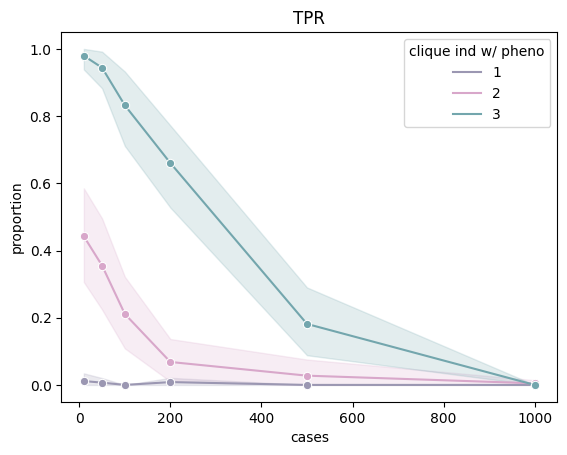

In [14]:
sns.lineplot(x="cases", y="rate", data=tpr_df[tpr_df["type"] == "TPR"], 
             hue="clique ind w/ pheno", marker="o", palette=sns.color_palette(["#9B97B2", "#D8A7CA", "#73A6AD", "#C1E6E3"]))
plt.ylabel("proportion")
plt.title("TPR")
plt.show()

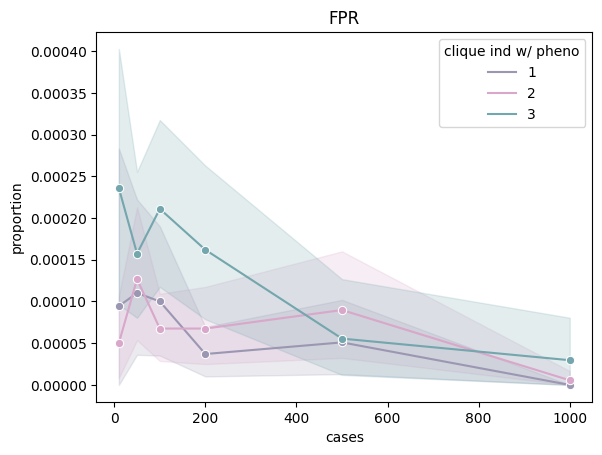

In [15]:
sns.lineplot(x="cases", y="rate", data=tpr_df[tpr_df["type"] == "FPR"], 
             hue="clique ind w/ pheno", marker="o", 
             palette=sns.color_palette(["#9B97B2", "#D8A7CA", "#73A6AD", "#C1E6E3"]))
plt.ylabel("proportion")
plt.title("FPR")
plt.show()

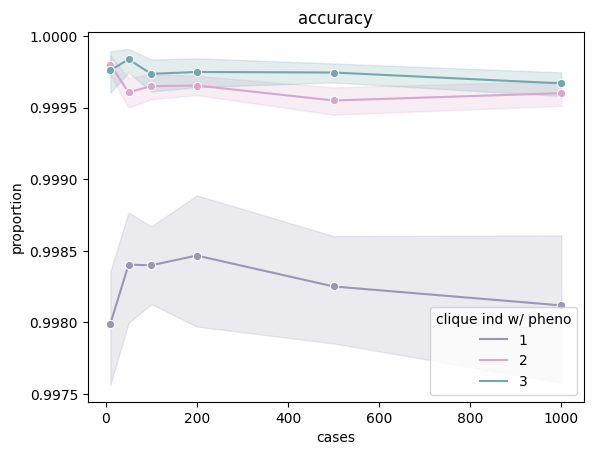

In [16]:
sns.lineplot(x="cases", y="rate", data=tpr_df[tpr_df["type"] == "accuracy"], 
             hue="clique ind w/ pheno", marker="o", 
             palette=sns.color_palette(["#9B97B2", "#D8A7CA", "#73A6AD", "#C1E6E3"]))
plt.ylabel("proportion")
plt.title("accuracy")
plt.show()

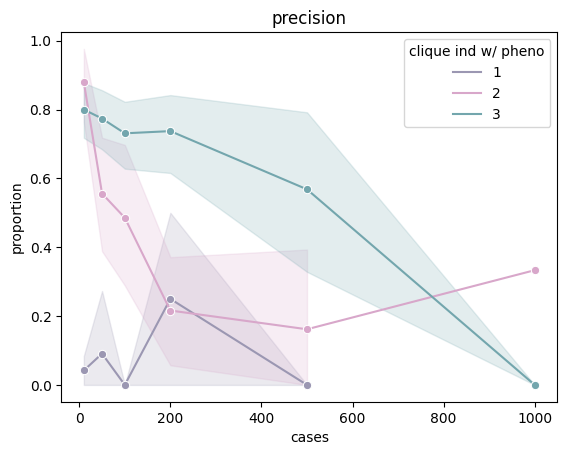

In [18]:
sns.lineplot(x="cases", y="rate", data=tpr_df[tpr_df["type"] == "precision"], 
             hue="clique ind w/ pheno", marker="o", 
             palette=sns.color_palette(["#9B97B2", "#D8A7CA", "#73A6AD", "#C1E6E3"]))
plt.ylabel("proportion")
plt.title("precision")
plt.show()

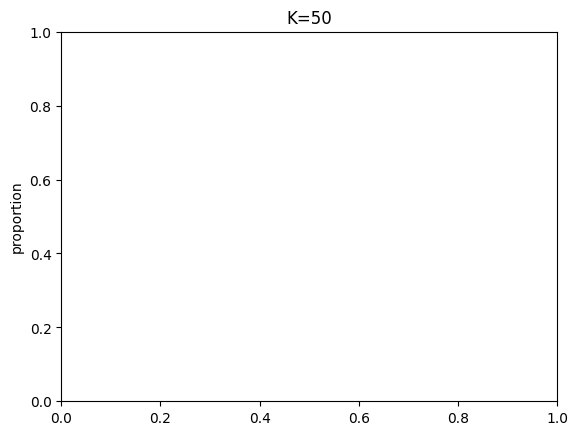

In [21]:
k=50
sns.lineplot(x="cases", y="proportion", data=top_k_df[top_k_df["k"] == k], 
             hue="clique ind w/ pheno", marker="o",
             palette=sns.color_palette(["#9B97B2", "#D8A7CA", "#73A6AD", "#C1E6E3"]))
plt.ylabel("proportion")
plt.title(f"K={k}")
plt.show()

In [64]:
regenie = pd.read_csv(f"pr_phenotype_simulations/output/simulated_pheno_100_clique2.regenie", sep=" ")

In [81]:
fdr(regenie, 10)

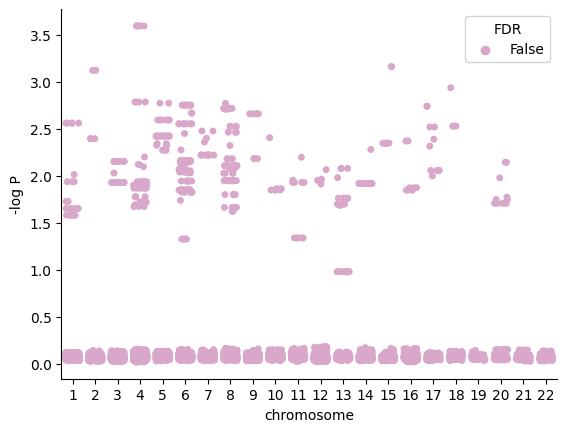

In [82]:
order = [str(i) for i in range(1, 23)]

sns.stripplot(x="CHROM", y="-log P", data=regenie, order=order, hue="FDR", jitter=0.3, 
               palette=sns.color_palette(["#D8A7CA", "#C7B8EA"]*11))
# plt.title(f"simulation v1 pheno{pheno_num}")
plt.xlabel("chromosome")
sns.despine()
plt.show()


In [67]:
true = pkl.load(open(f"pr_phenotype_simulations/input/redo/simulated_pheno_size100_clique_size2.pkl", "rb"))

# prioritization 

In [49]:
def fdr(regenie, pheno_num): 
    
    regenie["P"] = 10**(-regenie[f"LOG10P.Y{pheno_num}"])
    regenie["-log P"] = -(np.log10(regenie["P"])) 
    regenie["FDR"] = multipletests(regenie["P"], method="fdr_bh", alpha=0.1)[0]


In [62]:
fdr_passing = pd.DataFrame()

for s in [3]:
    for p in [10]:
        
        
        true = pkl.load(open(f"aj_phenotype_simulations/input/simulated_pheno_size{p}_clique_size{s}_max3.pkl", "rb"))
        true_pheno = pd.read_csv(f"aj_phenotype_simulations/input/simulated_pheno_{p}_clique_size{s}_max3.txt", sep="\t")
        regenie = pd.read_csv(f"aj_phenotype_simulations/output/simulated_pheno_{p}_clique_size{s}_max3.regenie", sep=" ")


#         true = pkl.load(open(f"pr_phenotype_simulations/input/redo/simulated_pheno_size{p}_clique_size{s}.pkl", "rb"))
#         true_pheno = pd.read_csv(f"pr_phenotype_simulations/input/redo/simulated_pheno_{p}_clique_size{s}.txt", sep="\t")
#         regenie = pd.read_csv(f"pr_phenotype_simulations/output/simulated_pheno_{p}_clique{s}.regenie", sep=" ")

        for i in range(1, 50):
            fdr(regenie, i)
            
            true_dict = true[i - 1]
            true_ids = list(true_dict.values())[0]

            if len(true_ids) >= 1:
                filtered_df = geno[geno["FID"].isin(true_ids)]
                true_cols = [col[:-2] for col in filtered_df.columns[(filtered_df == 2).all()].tolist()]
            else:
                true_cols = []
                
            regenie["true_status"] = regenie["ID"].isin(true_cols)
            
            sig = regenie[regenie["FDR"] == True]
#             sig = regenie.sort_values(by="P").head(n=100)
            if len(sig) >= 1: 
                
                sig["case_size"] = p 
                sig["experiment_clique_size"] = s
                sig["pheno_num"] = i 
            
                sig = sig.merge(recessive_cliques[["SNP", "C(HOM A1)"]], right_on="SNP", left_on="ID")
                
                clique_pheno_counts = []
                for ID in sig["ID"].values: 
                    ids_in_clique = geno[geno[f"{ID}_2"] == 2]["IID"].astype(str).values
                    clique_pheno_counts.append(len(true_pheno[(true_pheno["IID"].isin(
                        ids_in_clique)) & (true_pheno[f"pheno{i-1}"] == 2)]))
                
                sig["clique_pheno_counts"] = clique_pheno_counts
                sig = sig[["pheno_num", "ID", f"BETA.Y{i}", f"LOG10P.Y{i}", "true_status", "case_size", 
                           "experiment_clique_size", "C(HOM A1)", "clique_pheno_counts"]]
                
                sig.columns = ["pheno_num", "ID", "beta", "logP", "true_status", "total_cases", 
                           "experiment_clique_size", "homozygote_count", "clique_case_size"]
                
                fdr_passing = pd.concat([fdr_passing, sig])

In [63]:
sig

,pheno_num,ID,beta,logP,true_status,total_cases,experiment_clique_size,homozygote_count,clique_case_size
0,49,c99600_19,7.18697,8.10793,True,10,3,3,3
1,49,c101074_19,7.18697,8.10793,True,10,3,3,3


In [121]:
fdr_passing["prop_clique_case"] = fdr_passing["clique_case_size"]/fdr_passing["homozygote_count"]

In [123]:
# fdr_passing.to_csv("pr_phenotype_simulations/pr_fdr_passing.csv", index=False)

# score approach 

In [8]:
aj = pd.read_csv("aj_phenotype_simulations/aj_fdr_passing.csv")
pr = pd.read_csv("pr_phenotype_simulations/pr_fdr_passing.csv")

fdr_passing = pd.concat([aj, pr])

In [9]:
fdr_passing["score"] = (fdr_passing["logP"]/fdr_passing["logP"].max()) + (
    1/fdr_passing["total_cases"]) + (
    fdr_passing["prop_clique_case"]) + ( 
    (fdr_passing["beta"]/fdr_passing["beta"].max()))

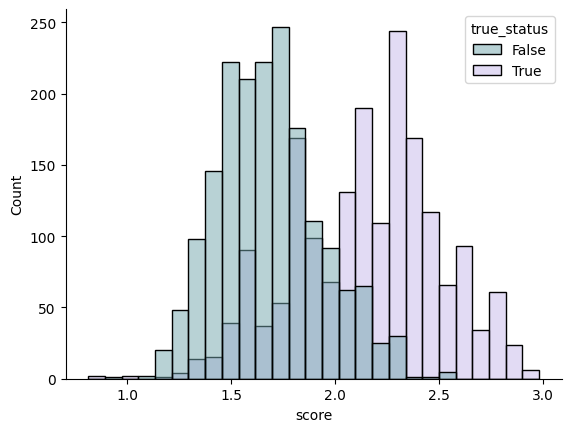

In [10]:
sns.histplot(x="score", data=fdr_passing, palette=sns.color_palette(["#73A6AD", "#C7B8EA"]),
             hue="true_status")
sns.despine()
plt.show()

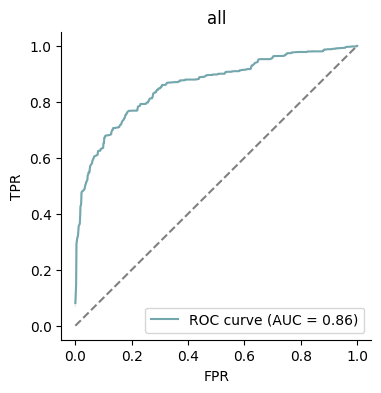

In [11]:
fpr, tpr, _ = roc_curve(fdr_passing["true_status"], fdr_passing["score"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color="#73A6AD")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="grey")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("all")
sns.despine()
plt.show()

In [12]:
t = 3
f = fdr_passing[fdr_passing["prop_clique_case"] == t/3]

In [13]:
fpr, tpr, _ = roc_curve(f["true_status"], f["score"])
roc_auc = auc(fpr, tpr)

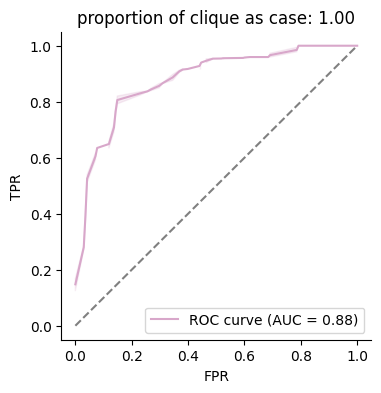

In [14]:
plt.figure(figsize=(4, 4))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color="#D8A7CA")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="grey")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("all")
plt.title(f"proportion of clique as case: {t/3:.2f}")
sns.despine()
plt.show()

# machine learning approach 

In [15]:
X = fdr_passing[["clique_case_size", "homozygote_count", "total_cases", "logP", "beta"]] 
y = fdr_passing["true_status"].replace({True:1, False:0})  

# clf = SVC(probability=True, kernel="poly")
clf = LogisticRegression()
loo = LeaveOneOut()

cv = StratifiedKFold(n_splits=20)
predicted_probs = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")

fdr_passing["predicted_prob"] = predicted_probs[:, 1] 


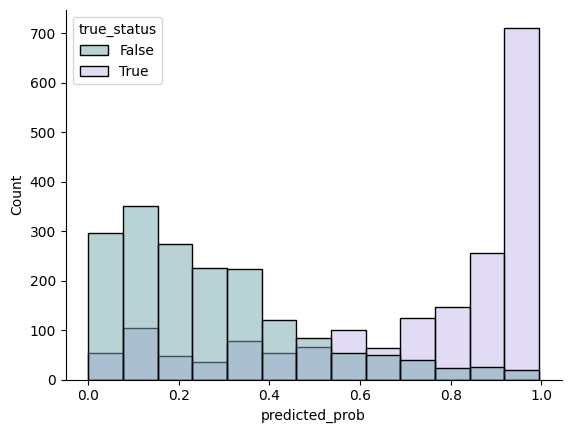

In [16]:
sns.histplot(x="predicted_prob", data=fdr_passing, palette=sns.color_palette(["#73A6AD", "#C7B8EA"]),
             hue="true_status")
sns.despine()
plt.show()

In [17]:
t = 1000
f = fdr_passing

In [18]:
fpr, tpr, _ = roc_curve(f["true_status"].replace({False:0, True:1}), f["predicted_prob"])
roc_auc = auc(fpr, tpr)

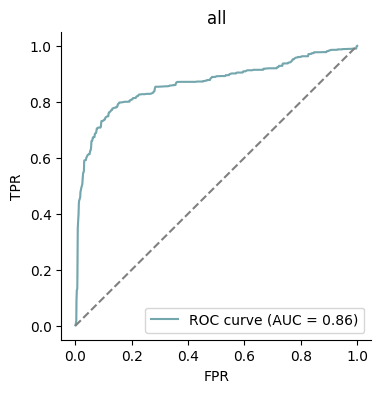

In [19]:
plt.figure(figsize=(4, 4))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color="#73A6AD")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="grey")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("all")
plt.title(f"all")
sns.despine()
plt.show()

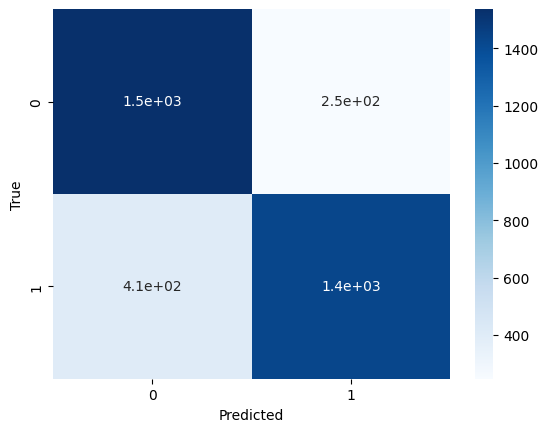

In [20]:
sns.heatmap(confusion_matrix(f["true_status"].replace({False:0, True:1}), 
                             round(f["predicted_prob"])), cmap="Blues", annot=True)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [21]:
f.sort_values(by="predicted_prob", ascending=False)

,pheno_num,ID,beta,logP,true_status,total_cases,experiment_clique_size,homozygote_count,clique_case_size,prop_clique_case,score,predicted_prob
2517,9,c63437_21,6.32432,9.11965,True,100,3,5,4.0,0.800000,2.543510,9.951043e-01
1577,22,c224277_7,7.78892,8.91859,True,10,3,3,3.0,1.000000,2.981332,9.950820e-01
1575,22,c222073_7,7.78892,8.91859,True,10,3,3,3.0,1.000000,2.981332,9.950820e-01
1574,22,c220485_7,7.78892,8.91859,True,10,3,3,3.0,1.000000,2.981332,9.950820e-01
1573,22,c219086_7,7.78892,8.91859,True,10,3,3,3.0,1.000000,2.981332,9.950820e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2523,11,c317899_10,2.91116,5.11326,False,100,3,29,5.0,0.172414,1.080743,1.550864e-04
4,7,c68117_5,6.17547,3.84334,True,10,2,11,0.0,0.000000,1.237682,1.732578e-05
2522,11,c313756_10,2.60014,4.42005,False,100,3,33,5.0,0.151515,0.947759,1.093419e-05
15,39,c68117_5,5.33407,3.31590,True,50,3,11,0.0,0.000000,1.002258,6.707210e-06


# real data

In [22]:
pr = pd.read_csv("../all_phenotypes_binary/significant_results/pr/pr_fdr10_significant_recessive.csv")
aj = pd.read_csv("../all_phenotypes_binary/significant_results/aj/aj_fdr10_significant_recessive.csv")

In [23]:
X = fdr_passing[["clique_case_size", "homozygote_count", "total_cases",
                 "logP", "prop_clique_case"]] 
y = fdr_passing["true_status"].replace({True:1, False:0}).values

model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [24]:
z = aj[["clique_case_count", "TWO_ALT_GENO_CTS", "pop case count",  "logP", "proportion of clique as case"]]
z.columns = ["clique_case_size", "homozygote_count", "total_cases", "logP", "prop_clique_case"]

In [25]:
y_pred = model.predict_proba(z)

In [29]:
aj["prediction"] = y_pred[:, 1]

In [31]:
# aj.sort_values(by="prediction", ascending=False).drop_duplicates(subset="phecode_string").head(n=20)

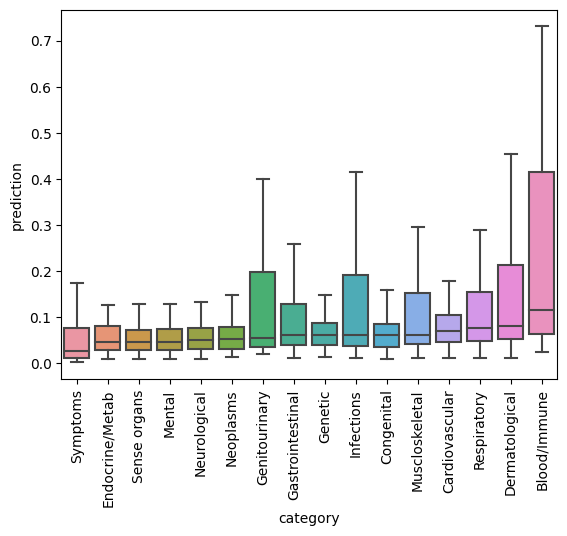

In [34]:
order = aj.groupby("category")["prediction"].median().sort_values().index
sns.boxplot(y="prediction", x="category", data=aj, order=order, showfliers=False)
plt.xticks(rotation=90)
plt.show()

# real data score 

In [35]:
pr["score"] = (pr["logP"]/pr["logP"].max()) + (
    1/pr["pop case count"]) + (
    pr["proportion of clique as case"]) 

In [36]:
aj["score"] = (aj["logP"]/aj["logP"].max()) + (
    1/aj["pop case count"]) + (
    aj["proportion of clique as case"]) + (
    (aj["Biome count"].max() - aj["Biome count"])/(
        aj["Biome count"].max()))

In [46]:
aj.to_csv("aj_phecode_with_predictions.csv", index=False)

In [47]:
aj.sort_values(by="score", ascending=False).drop_duplicates(subset="phecode_string").head(n=20)

,0,2,3,name,region,phecode,allele frq,count,logP,chi,...,phecode_string,category,Biome count,TWO_ALT_GENO_CTS,clique_case_count,proportion of clique as case,proportion of overall cases in clique,proportion of population cases in clique,prediction,score
7,18,63750001,64000000,c223084_18,chr18:63750001-64000000,EM_247.3,0.016221,7028,6.67666,26.9338,...,Disorders of phosphorus metabolism,Endocrine/Metab,320,3,3,1.000,0.009,0.077,0.982672,2.885021
10,11,7500001,7750000,c682012_11,chr11:7500001-7750000,ID_015,0.017075,7028,6.76112,27.3098,...,Clostridium,Infections,563,3,3,1.000,0.005,0.040,0.978512,2.852365
9,11,7500001,7750000,c682012_11,chr11:7500001-7750000,GI_526.12,0.017075,7028,6.73909,27.2117,...,Intestinal infection due to C. difficile,Gastrointestinal,545,3,3,1.000,0.006,0.041,0.978357,2.851924
8,11,7500001,7750000,c682012_11,chr11:7500001-7750000,ID_015.2,0.017075,7028,6.73909,27.2117,...,Clostridium difficile,Infections,545,3,3,1.000,0.006,0.041,0.978357,2.851924
20,5,160500001,160750000,c919656_5,chr5:160500001-160750000,CA_103.22,0.018782,7028,6.30747,25.2924,...,Squamous cell carcinoma of the skin,Neoplasms,431,3,3,1.000,0.007,0.021,0.952953,2.802189
128,8,93000001,93250000,c403671_8,chr8:93000001-93250000,RE_481.45,0.014158,7028,6.86254,27.7615,...,Cryptogenic organizing pneumonia,Respiratory,19,3,2,0.667,0.105,0.400,0.877369,2.790795
19,5,37500001,37750000,c100487_5,chr5:37500001-37750000,GU_596.2,0.012237,7028,6.43110,25.8417,...,Overactive bladder,Genitourinary,905,3,3,1.000,0.003,0.022,0.956915,2.756999
130,6,11750001,12000000,c918428_6,chr6:11750001-12000000,GE_974.11,0.008893,7028,6.60277,26.6050,...,Pigmentary retinal dystrophy,Genetic,27,3,2,0.667,0.074,0.400,0.856968,2.754687
27,5,90000001,90250000,c431212_5,chr5:90000001-90250000,CA_103.1,0.019778,7028,5.33680,20.9951,...,Melanomas of skin,Neoplasms,388,3,3,1.000,0.008,0.019,0.900871,2.675976
17,7,33500001,33750000,c106341_7,chr7:33500001-33750000,MS_742,0.014585,7028,5.97849,23.8328,...,Cartilage tear of knee,Muscloskeletal,1120,3,3,1.000,0.003,0.022,0.943865,2.668031


In [38]:
aj.sort_values(by="score", ascending=False).drop_duplicates(subset="phecode_string").head(n=20)

,0,2,3,name,region,phecode,allele frq,count,logP,chi,...,phecode_string,category,Biome count,TWO_ALT_GENO_CTS,clique_case_count,proportion of clique as case,proportion of overall cases in clique,proportion of population cases in clique,prediction,score
7,18,63750001,64000000,c223084_18,chr18:63750001-64000000,EM_247.3,0.016221,7028,6.67666,26.9338,...,Disorders of phosphorus metabolism,Endocrine/Metab,320,3,3,1.000,0.009,0.077,0.982672,2.885021
10,11,7500001,7750000,c682012_11,chr11:7500001-7750000,ID_015,0.017075,7028,6.76112,27.3098,...,Clostridium,Infections,563,3,3,1.000,0.005,0.040,0.978512,2.852365
9,11,7500001,7750000,c682012_11,chr11:7500001-7750000,GI_526.12,0.017075,7028,6.73909,27.2117,...,Intestinal infection due to C. difficile,Gastrointestinal,545,3,3,1.000,0.006,0.041,0.978357,2.851924
8,11,7500001,7750000,c682012_11,chr11:7500001-7750000,ID_015.2,0.017075,7028,6.73909,27.2117,...,Clostridium difficile,Infections,545,3,3,1.000,0.006,0.041,0.978357,2.851924
20,5,160500001,160750000,c919656_5,chr5:160500001-160750000,CA_103.22,0.018782,7028,6.30747,25.2924,...,Squamous cell carcinoma of the skin,Neoplasms,431,3,3,1.000,0.007,0.021,0.952953,2.802189
128,8,93000001,93250000,c403671_8,chr8:93000001-93250000,RE_481.45,0.014158,7028,6.86254,27.7615,...,Cryptogenic organizing pneumonia,Respiratory,19,3,2,0.667,0.105,0.400,0.877369,2.790795
19,5,37500001,37750000,c100487_5,chr5:37500001-37750000,GU_596.2,0.012237,7028,6.43110,25.8417,...,Overactive bladder,Genitourinary,905,3,3,1.000,0.003,0.022,0.956915,2.756999
130,6,11750001,12000000,c918428_6,chr6:11750001-12000000,GE_974.11,0.008893,7028,6.60277,26.6050,...,Pigmentary retinal dystrophy,Genetic,27,3,2,0.667,0.074,0.400,0.856968,2.754687
27,5,90000001,90250000,c431212_5,chr5:90000001-90250000,CA_103.1,0.019778,7028,5.33680,20.9951,...,Melanomas of skin,Neoplasms,388,3,3,1.000,0.008,0.019,0.900871,2.675976
17,7,33500001,33750000,c106341_7,chr7:33500001-33750000,MS_742,0.014585,7028,5.97849,23.8328,...,Cartilage tear of knee,Muscloskeletal,1120,3,3,1.000,0.003,0.022,0.943865,2.668031


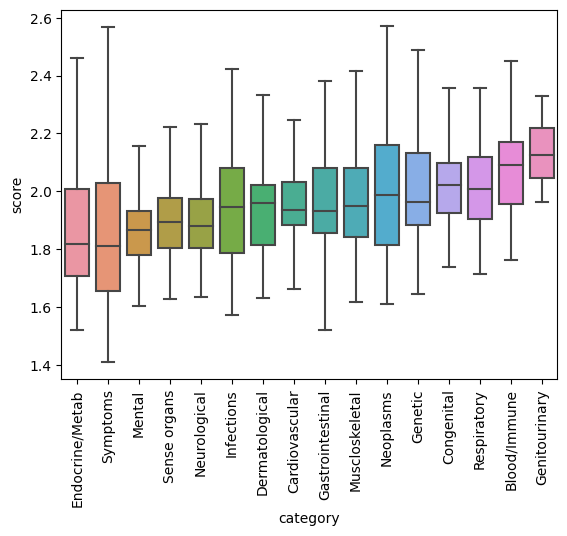

In [39]:
order = aj.groupby("category")["score"].mean().sort_values().index

sns.boxplot(y="score",x="category", data=aj, showfliers=False, order=order)
plt.xticks(rotation=90)
plt.show()

In [40]:
# pr.to_csv("pr_phecode_with_predictions.csv", index=False)